# QVM/QKM comparison

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime.fake_provider import FakeManilaV2,FakeBrisbane,FakeKyoto,FakeOsaka
from qiskit_algorithms.optimizers import SPSA,COBYLA,ADAM

import warnings
warnings.filterwarnings("ignore")

from qiskit_aer import AerSimulator,Aer
from qiskit import QuantumCircuit, transpile
import time
from sklearn import svm
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import ZZFeatureMap
from qiskit_ibm_runtime import QiskitRuntimeService

### Parameters

In [97]:
data_name = 'wine'  # 'DP_NODP', 'iris', 'wine'
max_data_size = 150
IS_NEW_RUN = False  # True if this is a new run, False if continuing from previous run

### Load data

In [98]:
# constants
RANDOM_STATE = 42

def normalizeDataWine():
    """
    Normalizes the Wine data
    """
    wine = load_wine()

    # Uncomment for having two classes by mixing the third class with the first one (so you have the class 1 and the class "not 1" labeled as 0)
    # Comment for having only two classes by removing the third class
    # wine.target[wine.target == 2] = 0

    wine_two_classes = (wine.target <2)

    X, Y = wine.data[wine_two_classes][:, :2], wine.target[wine_two_classes] # X with only the first two features
    # shuffle the data
    X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
    if max_data_size < len(X):
        X, Y = X[:max_data_size], Y[:max_data_size]

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

def normalizeDataIris():
    """
    Normalizes the Iris data
    """
    iris = load_iris()

    # Uncomment for having two classes by mixing the third class with the first one (so you have the class 1 and the class "not 1" labeled as 0)
    # Comment for having only two classes by removing the third class
    # iris.target[iris.target == 2] = 0

    iris_two_classes = (iris.target <2)

    X, Y = iris.data[iris_two_classes][:, 2:], iris.target[iris_two_classes] # X with only the last two features
    # shuffle the data
    X, Y = shuffle(X, Y, random_state=RANDOM_STATE)
    if max_data_size < len(X):
        X, Y = X[:max_data_size], Y[:max_data_size]

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

def normalizeDataImage(DATA_PATH = "./data/FEATURE_resultante_DP_NODP.csv"):
    """
    Normalizes the original images data
    """
    data = pd.read_csv(DATA_PATH)
    data = shuffle(data, random_state=RANDOM_STATE)
    if max_data_size < len(data):
        data = data[:max_data_size]
    X, Y = data[['area_pixels', ' mean_coords_x']].values, data[' class'].values

    # normalize the data
    scaler = MinMaxScaler(feature_range=(-0 * np.pi, 2 * np.pi))
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, Y_train, Y_test

if data_name == 'iris':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataIris()
elif data_name == 'wine':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataWine()
elif data_name == 'DP_NODP':
    TRAIN_DATA, TEST_DATA, TRAIN_LABELS, TEST_LABELS = normalizeDataImage()
print(TRAIN_DATA)

[[6.28318531 1.1175626 ]
 [5.55565859 1.40316194]
 [4.5139726  0.98097162]
 [4.18327864 1.22931886]
 [1.88495559 0.88163272]
 [1.28970646 1.71359599]
 [4.69585428 1.44041402]
 [2.31485774 0.98097162]
 [3.30693964 0.1986778 ]
 [3.00931507 1.06789315]
 [2.7612946  3.88663439]
 [1.73614331 1.66392654]
 [2.59594761 0.74504174]
 [0.69445732 2.06128214]
 [4.36516032 0.63328548]
 [5.01001355 1.75084808]
 [1.00861659 1.63909182]
 [4.4974379  1.22931886]
 [1.71960861 1.76326544]
 [2.14951076 0.44702504]
 [3.90218877 1.27898831]
 [4.08407045 1.32865776]
 [3.6541683  4.02322537]
 [5.25803402 4.09772955]
 [2.87703748 3.34027045]
 [4.74545838 1.16723205]
 [3.73684179 1.52733556]
 [2.7447599  0.98097162]
 [2.21564956 1.10514524]
 [5.27456872 1.19206678]
 [2.44713533 1.22931886]
 [5.52258919 1.50250083]
 [4.43129911 1.39074457]
 [3.34000903 1.62667446]
 [0.62831853 0.        ]
 [3.72030709 1.1175626 ]
 [4.67931958 0.95613689]
 [2.21564956 0.53394658]
 [5.53912389 3.53894825]
 [2.29832305 2.24754257]


## QVM

### Parameters

In [99]:
RERUN_OPTIMIZATION = IS_NEW_RUN

In [100]:
OPTIMIZATION_FILE_PATH = f"QVM_OPTIMIZER_RESULTS/{data_name}_optimization_result.pkl"

### Functions

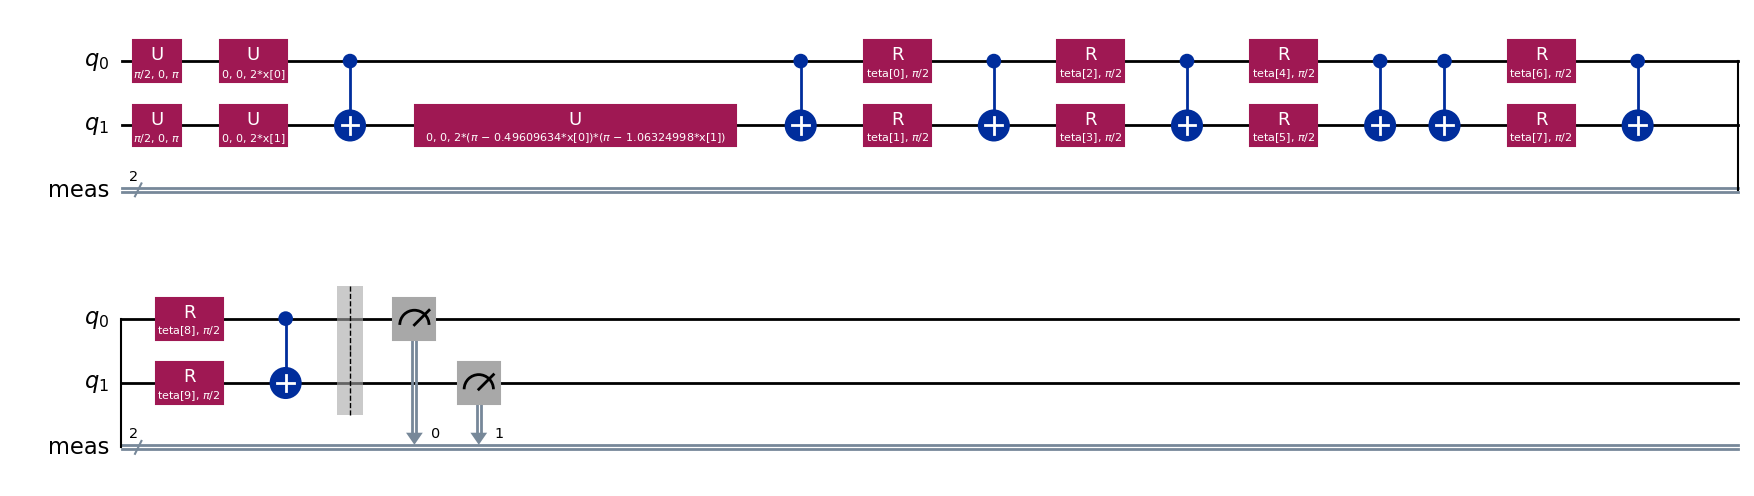

In [101]:
# 10-parameter variational quantum model
# define your parameters
x = ParameterVector('x', 2)
teta=ParameterVector('teta',10)

def ZZFeatureMap_10_parametros(feature_dimension=2, reps=1, theta_param=np.pi/2, x=x, teta=teta):
    # compute deterministic scaling factors from training data
    # TRAIN_DATA shape is (n_samples, 2) here (features already scaled by normalizeDataIris)
    factors = np.pi / np.max(TRAIN_DATA, axis=0)  # factor[0], factor[1]
    # print(factors)

    factors = [0.49609634, 1.06324998] # from original code on image processing
    circuit = QuantumCircuit(feature_dimension)
    for i in range(reps):
        if i == 0:
            circuit.h(range(feature_dimension))

        for j in range(feature_dimension):
            circuit.p(theta_param * x[j] * 1, j)

        circuit.cx(0, 1)

        circuit.p(theta_param * (np.pi - x[0] * factors[0]) * (np.pi - x[1] * factors[1]), 1)

        circuit.cx(0, 1)

        # Ensure that the indices are within the range of feature_dimension
        if feature_dimension > 1:
            circuit.ry(teta[0], 0)
            circuit.ry(teta[1], 1)

        if feature_dimension > 1:
            circuit.cx(0, 1)
            circuit.ry(teta[2], 0)
            circuit.ry(teta[3], 1)
        if feature_dimension > 1:
            circuit.cx(0, 1)
            circuit.ry(teta[4], 0)
            circuit.ry(teta[5], 1)
            circuit.cx(0, 1)
        if feature_dimension > 1:
            circuit.cx(0, 1)
            circuit.ry(teta[6], 0)
            circuit.ry(teta[7], 1)
            circuit.cx(0, 1)
            circuit.ry(teta[8], 0)
            circuit.ry(teta[9], 1)
            circuit.cx(0, 1)
            circuit.measure_all()

    return circuit

feature_map = ZZFeatureMap_10_parametros(feature_dimension=2, reps=1, theta_param=2, x=x,teta=teta)
# print(feature_map)

feature_map.decompose().draw("mpl")

In [102]:
def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    job = backend.run(circuits,shots=4000)
    #counts = job.result().get_counts()
    #######33
    results = job.result()
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    shots_per_execution = 100"""
    shots_per_execution = 50
    circuits = [circuit_instance_MIO(d, variational) for d in data]
    #backend = FakeManilaV2()
    backend = FakeOsaka()
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    #results = execute(circuits, backend, shots=shots_per_execution).result()
    job = backend.run(circuits,shots=100)
    #counts = job.result().get_counts()
    classification = [
        label_probability(job.result().get_counts(c)) for c in circuits]
    return classification

def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def cross_entropy_loss(classification, expected):

    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []

    def update(self, parameter):
        """Save intermediate results."""
        evaluation = len(self.evaluations) + 1  # Assuming evaluations are sequential
        cost = objective_function(parameter)
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

def circuit_instance_MIO(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """

    return feature_map.assign_parameters({x:data,teta:variational})

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)# clear objective value history

def comparar_probabilidades(probabilidades, labels):
    if len(probabilidades) != len(labels):
        raise ValueError("Lists of probabilities and labels must be the same length.")

    coincidencias = 0

    for prob_dict, label in zip(probabilidades, labels):
        # Get the class with the highest probability
        clase_predicha = max(prob_dict, key=prob_dict.get)

        # Check if the predicted class matches the actual label
        if clase_predicha == label:
            coincidencias += 1

    probabilidad_media = coincidencias / len(labels)
    return probabilidad_media

In [103]:
if RERUN_OPTIMIZATION:
        log = OptimizerLog()
        #optimizer = SPSA(maxiter=200,callback=callback_graph)
        optimizer = SPSA(maxiter=100)
        #optimizer = SPSA(maxiter=50, learning_rate=0.05, perturbation=0.05)
        #optimizer=COBYLA(maxiter=40 rhobeg=2.0,callback=log.update)
        optimizer = COBYLA(maxiter=100,callback=log.update)
        #optimizer =ADAM(maxiter=5)
        #optimizer = SPSA(maxiter=50)

        # Run the optimization
        # bounds = [(0, 3), (0, 2)]
        # bounds = [(0, 1.1), (0, 1.1)]


        # Record the start time
        inicio_tiempo = time.time()


        # for 10 PARAM. intial value
        # opt_var=np.random.rand(10)*2*np.pi
        # print(opt_var)
        opt_var=np.array([0.10125839, 2.18830448, 4.16274186, 3.3403106, 2.35531117, 0.43235425,
                3.43275685, 1.82333407, 1.82281728, 3.01886616])
        initial_point=opt_var
        result = optimizer.minimize(objective_function, initial_point)

        # Record the completion time
        fin_tiempo = time.time()
        # Calculate the time difference
        tiempo_ejecucion = fin_tiempo - inicio_tiempo
        # Print the execution time
        print(f"Time of the execution: {tiempo_ejecucion} s")

        print(result)

        with open(OPTIMIZATION_FILE_PATH, "wb") as f:
                pickle.dump(result, f)
else:
        with open(OPTIMIZATION_FILE_PATH, "rb") as f:
                result = pickle.load(f)

        print("Recovered result:", result)

Recovered result: {   'fun': np.float64(0.5888695542731045),
    'jac': None,
    'nfev': 96,
    'nit': None,
    'njev': None,
    'x': array([0.05716296, 3.12712063, 4.10320108, 3.34741248, 2.33045871,
       0.41975611, 3.39812898, 2.26717326, 2.79681264, 3.09559138])}


In [104]:
opt_var=result.x
print(f"Opt var : {opt_var}")

""" In this final part we can calculate the accuracy with this set of parameters after the optimization process.
"""
resultado = comparar_probabilidades(classification_probability(TRAIN_DATA,opt_var), TRAIN_LABELS)

print(f"The average probability of matching is for train : {resultado}")

resultado = comparar_probabilidades(classification_probability(TEST_DATA,opt_var), TEST_LABELS)
print(f"The average probability of matching is for test : {resultado}")


Opt var : [0.05716296 3.12712063 4.10320108 3.34741248 2.33045871 0.41975611
 3.39812898 2.26717326 2.79681264 3.09559138]


The average probability of matching is for train : 0.7211538461538461
The average probability of matching is for test : 0.5384615384615384


## QKM

### Parameters

In [105]:
row_to_compare = 40 # Make sure there are at least that number of samples in TRAIN_DATA
idx_row_to_compare = row_to_compare - 1  # zero-based index
size_of_plot=len(TRAIN_DATA)

RERUN_KERNEL_SIMULATION=IS_NEW_RUN
RERUN_KERNEL_REAL=IS_NEW_RUN
RERUN_KERNEL_TESTS=IS_NEW_RUN

In [106]:
SAVED_SIMULATION_MATRIX=f'./FEATURE_RESULTS/QKM_RESULTS_TWO_QUBITS/simulation_kernel_matrix_{data_name}_TRAIN.npy'
SAVED_COUNTS_FILE_PATH = f"./FEATURE_RESULTS/QKM_RESULTS_TWO_QUBITS/{data_name}_fake_osaka_kernel_row{row_to_compare}_results_counts.txt"
SAVED_SIMULATION_MATRIX_TESTS=f'./FEATURE_RESULTS/QKM_RESULTS_TWO_QUBITS/simulation_kernel_matrix_{data_name}_TEST.npy'

In [107]:
"""
This part is about estimating the kernel with a real quantum computer
"""
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="........8e5338f3752cf34eaa427........", overwrite=True, set_as_default=True)
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

"""
This part let us use a fake backend to test the code without using a real quantum computer
"""
backend =FakeOsaka()

### Functions

In [108]:
zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=1)

zz_feature_map_reference.decompose().draw()

┌───┐┌───────────┐                                        
q_0: ┤ H ├┤ P(2*x[0]) ├──■──────────────────────────────────■──
     ├───┤├───────────┤┌─┴─┐┌────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P(2*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└───────────┘└───┘└────────────────────────────┘└───┘

In [109]:
def zz_feature_map(circuit, x):
    # ZZMap modificado
    for i in range(2):
        circuit.h(i)
    circuit.rz(2 * x[0], 0)
    circuit.rz(2 * x[1], 1)
    circuit.cx(0, 1)
    circuit.rz(2 * (np.pi - x[0]) * (np.pi - x[1]), 1)
    circuit.cx(0, 1)

def inverse_zz_feature_map(circuit, x):
    # Invertir ZZMap
    circuit.cx(0, 1)
    circuit.rz(-2 * (np.pi - x[0]) * (np.pi - x[1]), 1)
    circuit.cx(0, 1)
    circuit.rz(-2 * x[1], 1)
    circuit.rz(-2 * x[0], 0)
    for i in range(2):
        circuit.h(i)

def scalar_product(circuit, x, y):
    zz_feature_map(circuit, y)
    inverse_zz_feature_map(circuit, x)
    # backend = AerSimulator('statevector_simulator')
    backend = Aer.get_backend('statevector_simulator')
    t_qc = transpile(circuit, backend)
    result = backend.run(t_qc).result()
    statevector = result.get_statevector(circuit)
    probs = np.abs(statevector)**2
    return probs


def kernel_gram_matrix_full(X1, X2):
    print("Calculating Gram matrix")

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        print(int(i / len(X1) * 100), "%")
        for j, x2 in enumerate(X2):
            qc = QuantumCircuit(2, 2)
            x1 = x1.flatten()
            x2 = x2.flatten()
            prob = scalar_product(qc, x1, x2)[0]  #Use only the probability of state '00'
            gram_matrix[i, j] = prob

    return gram_matrix


#If the matrix is ​​square, this is easier.
# the dimension of x1 and x2 are equal
def kernel_gram_matrix_full_symmetric(X1, X2):
    print("Calculando matriz de Gram")

    num_samples_X1 = X1.shape[0]


    gram_matrix = np.zeros((num_samples_X1, num_samples_X1))  # Make sure you have the correct size

    # Calculate only the upper half of the matrix
    for i in range(num_samples_X1):
        print(int(i / num_samples_X1 * 100), "%")
        for j in range(i, num_samples_X1):  # Only calculate the top half
            qc = QuantumCircuit(2, 2)
            x1 = X1[i].flatten()
            x2 = X2[j].flatten()

            prob = scalar_product(qc, x1, x2)[0]
            gram_matrix[i, j] = prob
            gram_matrix[j, i] = prob  # Symmetry: assigning the same value to the lower half

    return gram_matrix

def visualize_kernel_matrix(kernel_matrix):
    plt.imshow(kernel_matrix, cmap='viridis', interpolation='none', origin='lower', extent=[0, len(kernel_matrix), 0, len(kernel_matrix)])
    cbar = plt.colorbar(label='kernel matrix value')
    cbar.ax.yaxis.set_tick_params(labelsize=12)
    cbar.set_label('kernel matrix value', weight='bold', fontsize=14)
    plt.title('Kernel Matrix Visualization', fontweight='bold', fontsize=16)
    plt.xlabel('Data Index (X1)', fontweight='bold', fontsize=14)
    plt.ylabel('Data Index (X2)', fontweight='bold', fontsize=14)

    # Aumentar el tamaño y poner en negrita los números de los ejes
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    plt.show()

def make_overlap_circuit(x, y):
    """Return composed feature_map(y) ∘ inverse_feature_map(x) with measurements."""
    zz_y = zz_feature_map_reference.assign_parameters(y)
    zz_x = zz_feature_map_reference.assign_parameters(x)
    zzinv = zz_x.inverse()
    circ = zz_y.compose(zzinv, qubits=[0, 1])   # adjust qubits for n_qubits
    circ.measure_all()
    return circ

### Simulation

We compute the kernel matrix using statevector simulation.

- **Deterministic**: The result is exact and reproducible, unlike real quantum hardware, which is probabilistic.
- **No Noise**: Statevector simulations do not account for quantum noise or errors, which are present in real quantum devices.
- **Resource-Intensiv**e: Simulating large quantum circuits (many qubits) becomes computationally expensive because the statevector size grows exponentially with the number of qubits.

In [110]:
matrix_simetrica=[]
if RERUN_KERNEL_SIMULATION:
    import time
    inicio_tiempo = time.time()
    matrix_simetrica = kernel_gram_matrix_full_symmetric(TRAIN_DATA, TRAIN_DATA)
    fin=time.time()
    tiempo=inicio_tiempo-fin
    print(tiempo)
    # Save the matrix to a .npy file
    np.save(SAVED_SIMULATION_MATRIX, matrix_simetrica)
else:
    # Load the matrix from the .npy file
    matrix_simetrica=np.load(SAVED_SIMULATION_MATRIX, matrix_simetrica)

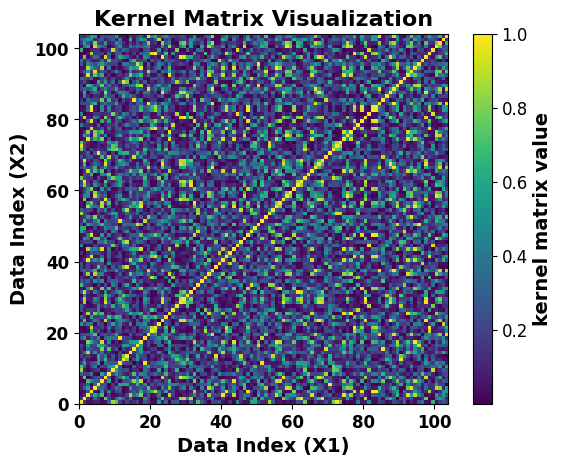

In [111]:
# Visualizar la matriz del kernel
visualize_kernel_matrix(matrix_simetrica)

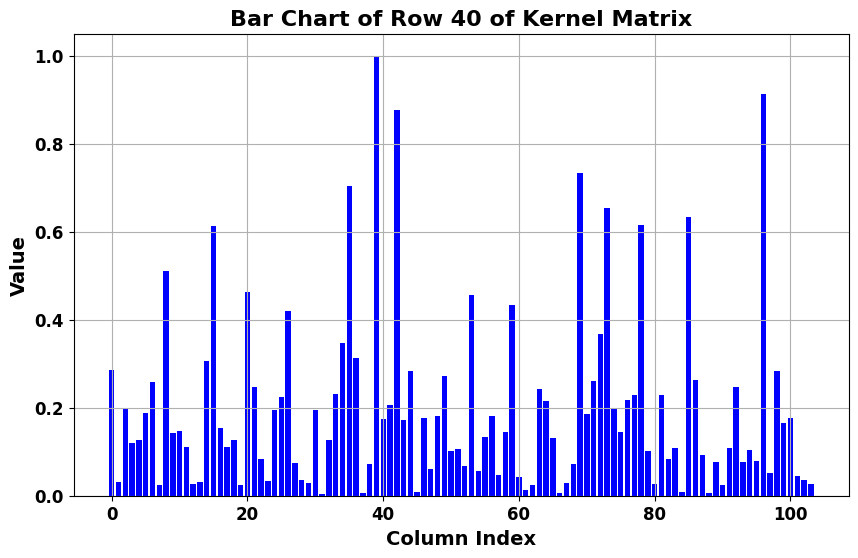

In [112]:
# Select row of the matrix
corresponding_sim_row = matrix_simetrica[idx_row_to_compare]

# Crear el diagrama de barras de la fila
plt.figure(figsize=(10, 6))
plt.bar(range(size_of_plot), corresponding_sim_row, color='b')
plt.title(f'Bar Chart of Row {row_to_compare} of Kernel Matrix', fontweight='bold', fontsize=16)
plt.xlabel('Column Index', fontweight='bold', fontsize=14)
plt.ylabel('Value', fontweight='bold', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(True)
plt.show()

### Hardware calculations
We run this time on (real or fake) quantum hardware

In [113]:
if RERUN_KERNEL_REAL:
    counts = []
    raw_circuits = []
    transpiled_circuits = []
    
    pairs_to_run = [(TRAIN_DATA[idx_row_to_compare].flatten(), TRAIN_DATA[j].flatten()) for j in range(len(TRAIN_DATA))]

    for (x, y) in pairs_to_run:
        raw_circuits.append(make_overlap_circuit(x.flatten(), y.flatten()))

    # now transpile all raw circuits for the backend once, storing order
    sim_noise = AerSimulator.from_backend(backend)   # uses target backend properties / noise
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    transpiled_circuits = [passmanager.run(c) for c in raw_circuits]

    # submit transpiled_circuits to Sampler (order preserved)
    sampler = Sampler(backend)
    job = sampler.run(transpiled_circuits)
    result = job.result()

In [114]:
if RERUN_KERNEL_REAL:
    # Iterate over the results to print and save the counts
    counts_data = []
    with open(SAVED_COUNTS_FILE_PATH, 'w') as f:
        for idx, pub_result in enumerate(result):
            counts = pub_result.data.meas.get_counts()
            f.write(f"Counts for pub {idx}: {counts}\n")
            print(f" > Counts for pub {idx}: {counts}")
            counts_data.append(counts)
else:
    counts_data = []
    with open(SAVED_COUNTS_FILE_PATH, 'r') as f_read:
        for line in f_read:
            if line.startswith("Counts for pub"):
                # Extract the dictionary part from the line
                counts_str = line.split(":", 1)[1].strip()
                # Convert string dict to actual dict
                try:
                    counts = eval(counts_str)
                    counts_data.append(counts)
                except (SyntaxError, ValueError) as e:
                    print(f"Error parsing line: {line.strip()}")
                    print(e)

    print(f"Total circuits processed: {len(counts_data)}")

Total circuits processed: 104


In [115]:
#Extract the counts for '00' from each post and calculate the total sum of counts per post
counts_00 = []
for counts in counts_data:
    total_counts = sum(counts.values())
    count_00 = counts.get('00', 0)
    count_00_pu = count_00 / total_counts if total_counts != 0 else 0  # Evitar división por cero
    counts_00.append(count_00_pu)


#Print '00' counts in p.u. to verify
for idx, count in enumerate(counts_00):
    print(f"Counts of '00' in p.u. for pub {idx}: {count:.4f}")


Counts of '00' in p.u. for pub 0: 0.2930
Counts of '00' in p.u. for pub 1: 0.0479
Counts of '00' in p.u. for pub 2: 0.2129
Counts of '00' in p.u. for pub 3: 0.1240
Counts of '00' in p.u. for pub 4: 0.1504
Counts of '00' in p.u. for pub 5: 0.1973
Counts of '00' in p.u. for pub 6: 0.2500
Counts of '00' in p.u. for pub 7: 0.0469
Counts of '00' in p.u. for pub 8: 0.5059
Counts of '00' in p.u. for pub 9: 0.1299
Counts of '00' in p.u. for pub 10: 0.1543
Counts of '00' in p.u. for pub 11: 0.1074
Counts of '00' in p.u. for pub 12: 0.0420
Counts of '00' in p.u. for pub 13: 0.0381
Counts of '00' in p.u. for pub 14: 0.3115
Counts of '00' in p.u. for pub 15: 0.5723
Counts of '00' in p.u. for pub 16: 0.1514
Counts of '00' in p.u. for pub 17: 0.1309
Counts of '00' in p.u. for pub 18: 0.1162
Counts of '00' in p.u. for pub 19: 0.0371
Counts of '00' in p.u. for pub 20: 0.4541
Counts of '00' in p.u. for pub 21: 0.2480
Counts of '00' in p.u. for pub 22: 0.0732
Counts of '00' in p.u. for pub 23: 0.0547
Co

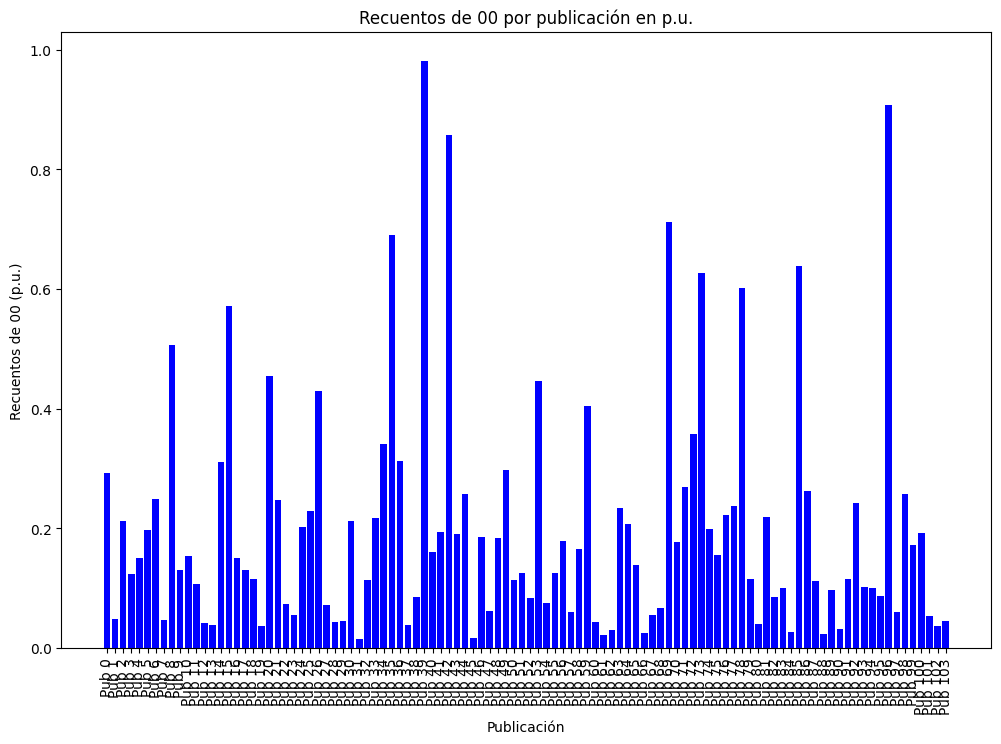

In [116]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define the indexes and values ​​for the chart
pub_indices = range(size_of_plot)

# Create the bars
ax.bar(pub_indices, counts_00[:size_of_plot], color='blue')

# Add tags and title
ax.set_xlabel('Publicación')
ax.set_ylabel('Recuentos de 00 (p.u.)')
ax.set_title('Recuentos de 00 por publicación en p.u.')
ax.set_xticks(pub_indices)
ax.set_xticklabels([f'Pub {i}' for i in pub_indices], rotation=90)

# Mostrar el gráfico
plt.show()

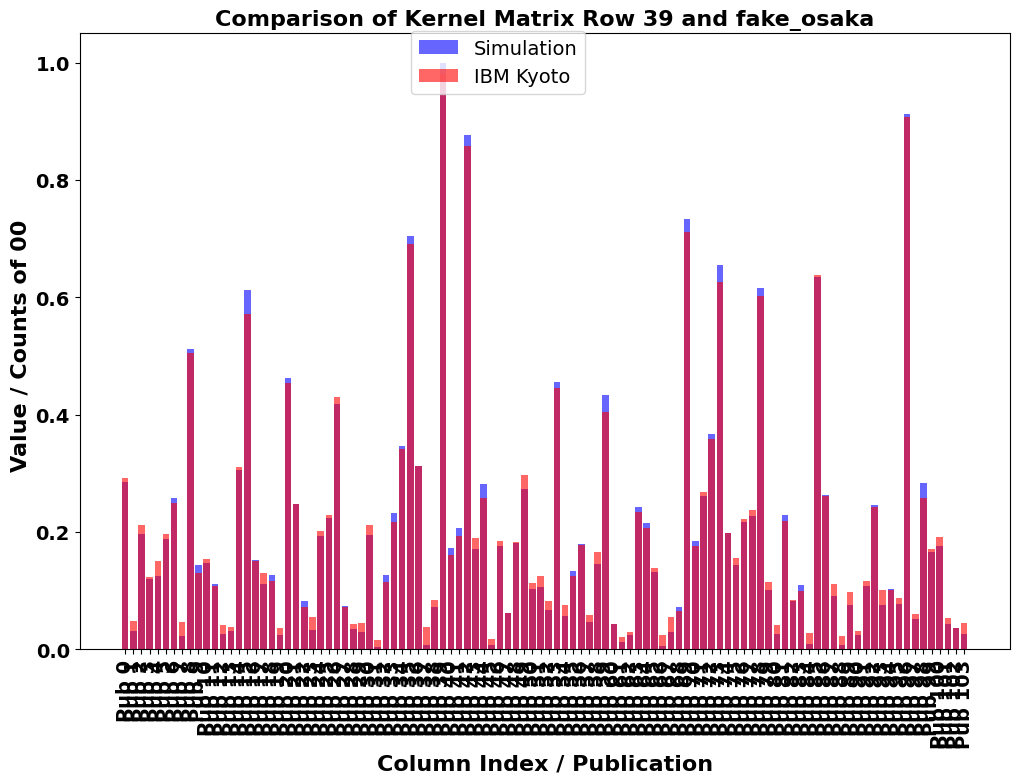

In [117]:
# Select tested row from the matrix
corresponding_sim_row = matrix_simetrica[idx_row_to_compare]

# Create the combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define the indices for the plot
indices = range(size_of_plot)

# Create the bars for the corresponding row of the kernel matrix
ax.bar(indices, corresponding_sim_row, color='b', alpha=0.6, label='Simulation')

# Create the bars for the normalized counts of 00
ax.bar(indices, counts_00, color='r', alpha=0.6, label='IBM Kyoto')

# Add labels and title in bold and increase font size
ax.set_xlabel('Column Index / Publication', fontweight='bold', fontsize=16)
ax.set_ylabel('Value / Counts of 00 ', fontweight='bold', fontsize=16)
ax.set_title(f"Comparison of Kernel Matrix Row {idx_row_to_compare} and {backend.name}", fontweight='bold', fontsize=16)

# Modify the x-axis tick labels
ax.set_xticks(indices)
ax.set_xticklabels([f'Pub {i}' for i in indices], rotation=90, fontsize=14, fontweight='bold')

# Modify the y-axis tick labels
plt.yticks(fontsize=14, fontweight='bold')


ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.02), fontsize=14)
# Show the plot
plt.show()


In [118]:
print("Checking SVC with train...")

clf = svm.SVC(kernel="precomputed")
clf.fit(matrix_simetrica, TRAIN_LABELS)

#Record the start time
inicio_tiempo = time.time()
sol = clf.predict(matrix_simetrica)

success = 0

# Calculate the time difference
tiempo_ejecucion = time.time()- inicio_tiempo

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")

Checking SVC with train...
Tiempo de ejecución: 0.001033782958984375 segundos


In [119]:
clf = svm.SVC(kernel="precomputed")

# Fit the model to the training data
"""
finds the optimal hyperplane that separates the different classes based on the training data and the associated labels.
The objective function of the SVM is convex, meaning there are no local minima.
"""

start_time = time.time()
clf.fit(matrix_simetrica, TRAIN_LABELS)
training_time = time.time() - start_time
print("Tiempo de entrenamiento:", training_time, "segundos")

Tiempo de entrenamiento: 0.005341529846191406 segundos


In [120]:
inicio_tiempo = time.time()
TRAIN_LABELS=TRAIN_LABELS
success = 0
for i in range(len(TRAIN_LABELS)):
    if sol[i] == TRAIN_LABELS[i]:
        success += 1

print("Precisión del train: ", success/len(sol)*100, "%")

# Registra el tiempo de finalización
fin_tiempo = time.time()

# Calcula la diferencia de tiempo
tiempo_ejecucion = fin_tiempo - inicio_tiempo

print(f"Tiempo de ejecución de compro train: {tiempo_ejecucion} segundos")

Precisión del train:  68.26923076923077 %
Tiempo de ejecución de compro train: 0.0006825923919677734 segundos


In [121]:
print("Comprobando con test...")
# Registra el tiempo de inicio
inicio_tiempo = time.time()

tests_matrix = []
if RERUN_KERNEL_TESTS:
    tests_matrix = kernel_gram_matrix_full(TEST_DATA, TRAIN_DATA)
    np.save(SAVED_SIMULATION_MATRIX_TESTS, tests_matrix)
else:
    tests_matrix = np.load(SAVED_SIMULATION_MATRIX_TESTS)

sol = clf.predict(tests_matrix)


y_test=TEST_LABELS
success = 0


# Calcula la diferencia de tiempo
tiempo_ejecucion = time.time()- inicio_tiempo

print(f"Tiempo de ejecución: {tiempo_ejecucion} segundos")

Comprobando con test...
Tiempo de ejecución: 0.0052373409271240234 segundos


In [122]:
inicio_tiempo = time.time()
y_test=TEST_LABELS
success = 0
for i in range(len(y_test)):
    if sol[i] == y_test[i]:
        success += 1

print("Precisión del test: ", success/len(sol)*100, "%")

# Registra el tiempo de finalización
fin_tiempo = time.time()

# Calcula la diferencia de tiempo
tiempo_ejecucion = fin_tiempo - inicio_tiempo

print(f"Tiempo de ejecución de compro test: {tiempo_ejecucion} segundos")

Precisión del test:  65.38461538461539 %
Tiempo de ejecución de compro test: 0.0005526542663574219 segundos


## Comparison

In [ ]:
WRITE_CSV_ENTRY=IS_NEW_RUN

In [124]:
if WRITE_CSV_ENTRY:
    # Comparison: save experiment metadata + results, and provide loader/aggregator + plots

    import os, json, datetime, pandas as pd, time
    from pathlib import Path

    OUT_DIR = Path("./EXPERIMENT_RESULTS")
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    SUMMARY_CSV = OUT_DIR / "summary.csv"

    def safe_run_qvm_eval():
        """Re-evaluate QVM classification probabilities (may run simulator/fake backend)."""
        try:
            t0 = time.time()
            qvm_train_acc = comparar_probabilidades(classification_probability(TRAIN_DATA, opt_var), TRAIN_LABELS)
            t_train = time.time() - t0

            t0 = time.time()
            qvm_test_acc = comparar_probabilidades(classification_probability(TEST_DATA, opt_var), TEST_LABELS)
            t_test = time.time() - t0
        except Exception as e:
            print("QVM eval failed:", e)
            qvm_train_acc, qvm_test_acc, t_train, t_test = None, None, None, None
        return qvm_train_acc, qvm_test_acc, t_train, t_test

    def safe_run_qkm_eval():
        """Re-evaluate QKM: (re)use matrix_simetrica and tests_matrix to fit SVM and measure times/accuracy."""
        try:
            # train
            clf_local = svm.SVC(kernel="precomputed")
            t0 = time.time()
            clf_local.fit(matrix_simetrica, TRAIN_LABELS)
            train_fit_time = time.time() - t0

            t0 = time.time()
            pred_train = clf_local.predict(matrix_simetrica)
            pred_train_time = time.time() - t0
            train_acc = (pred_train == TRAIN_LABELS).sum() / len(TRAIN_LABELS)

            # test
            # ensure tests_matrix exists (computed or loaded earlier)
            tests_matrix = np.load(SAVED_SIMULATION_MATRIX_TESTS)

            t0 = time.time()
            pred_test = clf_local.predict(tests_matrix)
            test_pred_time = time.time() - t0
            test_acc = (pred_test == TEST_LABELS).sum() / len(TEST_LABELS)
        except Exception as e:
            print("QKM eval failed:", e)
            train_fit_time = pred_train_time = test_pred_time = None
            train_acc = test_acc = None
        return dict(train_fit_time=train_fit_time,
                    pred_train_time=pred_train_time,
                    train_acc=train_acc,
                    test_pred_time=test_pred_time,
                    test_acc=test_acc)

    # collect metadata
    experiment = {}
    experiment['timestamp'] = datetime.datetime.utcnow().isoformat()
    experiment['dataset'] = data_name  # change for other datasets
    experiment['n_train'] = int(TRAIN_DATA.shape[0])
    experiment['n_test'] = int(TEST_DATA.shape[0])
    experiment['n_features'] = int(TRAIN_DATA.shape[1])
    experiment['n_qubits'] = 2
    experiment['feature_map'] = 'custom_ZZ_modified'
    experiment['feature_map_params'] = {'reps':1, 'teta_params': len(teta) if 'teta' in globals() else None}
    experiment['qvm_simulation_method'] = 'statevector'
    experiment['qkm_simulation_method'] = 'statevector (matrix) + hardware row for comparison' if RERUN_KERNEL_REAL else 'statevector (matrix) + saved hardware counts'
    experiment['symmetric_kernel_used'] = True

    # optimizer metadata if available
    experiment['optimizer'] = 'unknown'
    try:
        # heuristics: if result exists and has attribute 'x' then optimization was run or loaded
        experiment['opt_var_shape'] = len(opt_var) if 'opt_var' in globals() else None
        experiment['optimizer_info'] = getattr(result, 'name', str(type(result))) if 'result' in globals() else None
    except Exception:
        pass

    # re-evaluate metrics (safe)
    qvm_train_acc, qvm_test_acc, qvm_train_time, qvm_test_time = safe_run_qvm_eval()
    experiment['qvm_train_acc'] = qvm_train_acc
    experiment['qvm_test_acc'] = qvm_test_acc
    experiment['qvm_train_time_s'] = qvm_train_time
    experiment['qvm_test_time_s'] = qvm_test_time

    qkm_results = safe_run_qkm_eval()
    experiment.update({f"qkm_{k}": v for k, v in qkm_results.items()})

    # save JSON file per experiment
    # fname = OUT_DIR / f"experiment_{experiment['timestamp'].replace(':','-')}.json"
    # with open(fname, "w") as f:
    #     json.dump(experiment, f, indent=2)
    # print("Saved experiment JSON to", fname)

    # append summary row to CSV for quick aggregation
    df_row = pd.DataFrame([{
        'timestamp': experiment['timestamp'],
        'dataset': experiment['dataset'],
        'n_train': experiment['n_train'],
        'n_test': experiment['n_test'],
        'n_qubits': experiment['n_qubits'],
        'qvm_train_acc': experiment['qvm_train_acc'],
        'qvm_test_acc': experiment['qvm_test_acc'],
        'qvm_train_time_s': experiment['qvm_train_time_s'],
        'qvm_test_time_s': experiment['qvm_test_time_s'],
        'qkm_train_acc': experiment['qkm_train_acc'],
        'qkm_test_acc': experiment['qkm_test_acc'],
        'qkm_train_fit_time_s': experiment['qkm_train_fit_time'],
        'qkm_test_pred_time_s': experiment['qkm_test_pred_time']
    }])

    if SUMMARY_CSV.exists():
        df_row.to_csv(SUMMARY_CSV, mode='a', header=False, index=False)
    else:
        df_row.to_csv(SUMMARY_CSV, index=False)
    print("Appended summary to", SUMMARY_CSV)

Appended summary to EXPERIMENT_RESULTS/summary.csv


,timestamp,dataset,n_train,n_test,n_qubits,qvm_train_acc,qvm_test_acc,qvm_train_time_s,qvm_test_time_s,qkm_train_acc,qkm_test_acc,qkm_train_fit_time_s,qkm_test_pred_time_s
0,2025-10-15T03:07:54.280942,iris,80,20,2,0.762500,0.800000,5.935988,6.114874,0.812500,0.800000,0.002104,0.000883
1,2025-10-16T21:09:14.659322,DP_NODP,120,30,2,0.800000,0.766667,10.301542,9.557637,0.975000,0.966667,0.003135,0.000254
2,2025-10-16T21:10:36.128626,wine,104,26,2,0.653846,0.615385,9.711137,8.958552,0.682692,0.653846,0.003604,0.000436


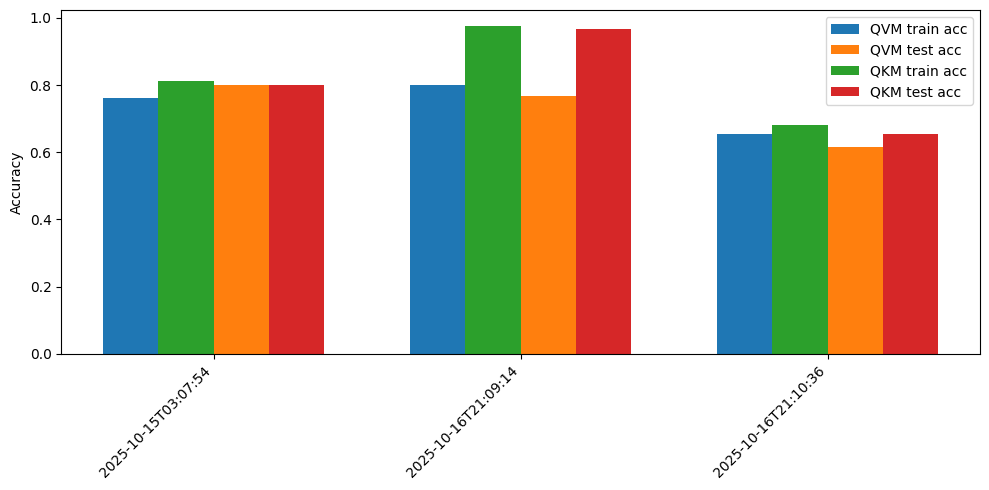

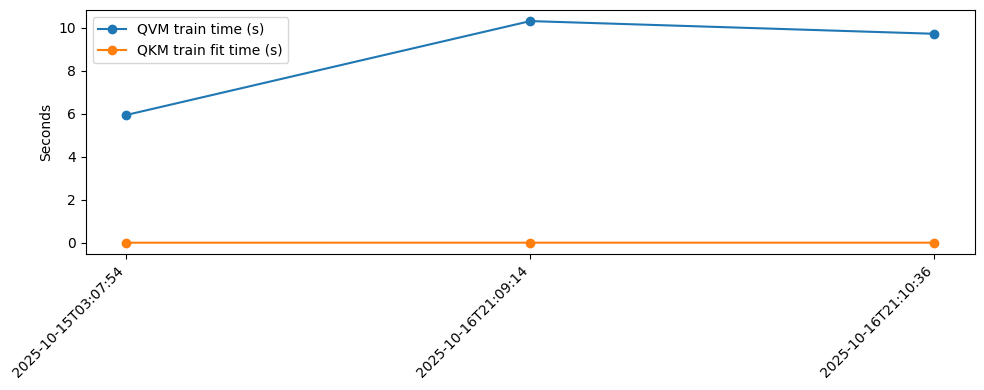

In [125]:
# Quick loader + plots to compare all saved experiments
def load_all_results_plot(summary_csv=SUMMARY_CSV, json_dir=OUT_DIR):
    if not summary_csv.exists():
        print("No summary file found:", summary_csv)
        return
    df = pd.read_csv(summary_csv)
    display(df)  # notebook-friendly

    # Plot accuracies (train/test) for QVM vs QKM for all experiments
    plt.figure(figsize=(10,5))
    x = range(len(df))
    width = 0.18  # slightly smaller width for better separation

    # Shift bars so that QVM and QKM bars for train/test do not overlap
    plt.bar([xi - 1.5*width for xi in x], df['qvm_train_acc'].fillna(0), width=width, label='QVM train acc')
    plt.bar([xi + 0.5*width for xi in x], df['qvm_test_acc'].fillna(0), width=width, label='QVM test acc')
    plt.bar([xi - 0.5*width for xi in x], df['qkm_train_acc'].fillna(0), width=width, label='QKM train acc')
    plt.bar([xi + 1.5*width for xi in x], df['qkm_test_acc'].fillna(0), width=width, label='QKM test acc')
    plt.xticks(x, df['timestamp'].str.slice(0,19), rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot timings (if present)
    if 'qvm_train_time_s' in df.columns:
        plt.figure(figsize=(10,4))
        plt.plot(df['timestamp'].str.slice(0,19), df['qvm_train_time_s'].fillna(0), marker='o', label='QVM train time (s)')
        plt.plot(df['timestamp'].str.slice(0,19), df['qkm_train_fit_time_s'].fillna(0), marker='o', label='QKM train fit time (s)')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Seconds')
        plt.legend()
        plt.tight_layout()
        plt.show()

# call loader to show current aggregated experiments
load_all_results_plot()